<h1 align="center"> t-Stochastic Nearest Neighbour Embeddings</h1>

t-SNE is an embedding technique that is commonly used to map high-dimensional data to 2 or 3 dimensions so that it can be viewed in scatterplots. The main idea behind t-SNE is to preserve points with small pairwise distances in the original data to the dimension reduced data.
 
t-SNE minimizes the divergence between two probability distributions:  

* a distribution that measures pairwise similarities of the input objects.
* a distribution that measures pairwise similarities of the corresponding low-dimensional points in the embedding. 

Assume we are given a data set of (high-dimensional) input objects $D = \{x_1, x_2, ... x_n\}$ and a distance function $d(x_i, x_j)$ computes a distance between a pair of objects. The t-SNE algorithm learn learns an s (typically 2 or 3) dimensional embedding in which each object is represented by a point $y_i \in \mathbb{R}^s$.



To this end, t-SNE defines joint probabilities $p_{ij}$ that measure the pairwise similarity between objects $x_i$ and $x_j$
by symmetrizing two conditional probabilities:
    
$$\begin{align}
p_{j \mid i} \\
 &= 0,\space if \space i = j \\
 &= \dfrac {exp(-d(x_i, x_j)^2 / 2 \sigma_i^2)} {\sum_{k \ne i} exp(-d(x_i, x_k)^2 / 2 \sigma_i^2)} otherwise
\end{align}$$

and 

$$\begin{align}
p_{ij} = \dfrac {p_{i \mid j} + p_{j \mid i)}} {2n}
\end{align}$$

In  the  above  equation,  the  bandwidth  of  the  Gaussian  kernels, $\sigma_i$ is  set  in  such  a  way that the  perplexity of the conditional distribution $P_{ij}$ equals a predefined perplexity $u$. As a result,  the  optimal  value  of
$\sigma_i$ varies  per  object:  in  regions  of  the  data  space  with  a higher  data  density, $\sigma_i$ tends  to  be  smaller  than  in  regions  of  the  data  space  with  lower density.

In the s-dimensional embedding, the similarities between two points $y_i$ and $y_j$, the low-dimensional models of  $x_i$ and $x_j$ are measured using a normalized heavy-tailed kernel. Specifically, the embedding similarity $q_{ij}$ between the two points between $y_i$ and $y_j$ is computed as a normalized Student-t kernel with a single degree of freedom.

$$\begin{align}
q_{ij} \\
 &= 0,\space if \space i = j \\
 &= \dfrac {{(1 + \lVert y_i - y_j \rVert ^2})^{-1}} {{\sum_{k \ne l} (1 + \lVert y_k - y_l \rVert ^2})^{-1}} otherwise
\end{align}$$

The locations of the embedding points $y_i$ are determined by minimizing the Kullback-Leibler divergence between the joint distributions P and Q:

$$C(P, Q) = KLD(P \mid\mid Q) = \sum_{i \ne j} {p_{ij}} log (\dfrac{p_{ij}} {q_{ij}})$$ 

# Resources

<a href="https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf">https://lvdmaaten.github.io/publications/papers/JMLR_2014.pdf</a>

In the code example below, we load classic MNIST dataset and reduce the dimensions to 2.

# Getting the Data

In [1]:
import numpy as np
import pandas as pd

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import seaborn as sns

We use the ``sklearn.datasets.load_digits`` method to load the MNIST data.

In [2]:
from sklearn.datasets import load_digits
digits_data = load_digits()

In [3]:
from IPython.display import display

display(dir(digits_data))
display(digits_data.data.shape)
display(digits_data.target.shape)

['DESCR', 'data', 'images', 'target', 'target_names']

(1797, 64)

(1797,)

This dataset contains data for 1797 images. Each image is an 8*8 matrix stored as a flat-packed array.

Next we combine the data and target into a single dataframe.

In [4]:
mnist_df = pd.DataFrame(index=digits_data.target, data=digits_data.data)

In [5]:
mnist_df.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,0.0,5.0,13.0,9.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,6.0,13.0,10.0,0.0,0.0,0.0
1,0.0,0.0,0.0,12.0,13.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,11.0,16.0,10.0,0.0,0.0
2,0.0,0.0,0.0,4.0,15.0,12.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,3.0,11.0,16.0,9.0,0.0
3,0.0,0.0,7.0,15.0,13.0,1.0,0.0,0.0,0.0,8.0,...,9.0,0.0,0.0,0.0,7.0,13.0,13.0,9.0,0.0,0.0
4,0.0,0.0,0.0,1.0,11.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,16.0,4.0,0.0,0.0


Next we find out How many images we have per label.

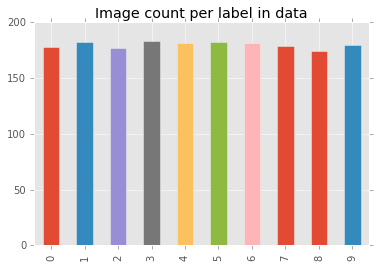

In [6]:
image_counts = mnist_df.groupby(mnist_df.index)[0].count()
ax = image_counts.plot(kind='bar', title='Image count per label in data')

Next we scale mnist_df so that every feature has zero mean and unit variance.

## Pairwise Distances, P and $\sigma_i$s

In [7]:
from sklearn.preprocessing import scale
mnist_df_scaled = pd.DataFrame(index=mnist_df.index, 
                               columns=mnist_df.columns, 
                               data=scale(mnist_df))

mnist_df_scaled.head()

,0,1,2,3,4,5,6,7,8,9,...,54,55,56,57,58,59,60,61,62,63
0,0.0,-0.335016,-0.043081,0.274072,-0.664478,-0.844129,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,0.086719,0.208293,-0.366771,-1.146647,-0.505670,-0.196008
1,0.0,-0.335016,-1.094937,0.038648,0.268751,-0.138020,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-0.249010,0.849632,0.548561,-0.505670,-0.196008
2,0.0,-0.335016,-1.094937,-1.844742,0.735366,1.097673,-0.409724,-0.125023,-0.059078,-0.624009,...,0.259230,-0.209785,-0.023596,-0.299081,-1.089383,-2.078218,-0.164037,1.565686,1.695137,-0.196008
3,0.0,-0.335016,0.377661,0.744919,0.268751,-0.844129,-0.409724,-0.125023,-0.059078,1.879691,...,1.072563,-0.209785,-0.023596,-0.299081,0.282736,0.208293,0.241430,0.379040,-0.505670,-0.196008
4,0.0,-0.335016,-1.094937,-2.551014,-0.197863,-1.020657,-0.409724,-0.125023,-0.059078,-0.624009,...,-0.757436,-0.209785,-0.023596,-0.299081,-1.089383,-2.306869,0.849632,-0.468564,-0.505670,-0.196008


From the scaled data, we must calculate the $P_{ij}$s. To do this we first calculate the pairwise distances between each pair of rows in the input data. For efficiency's sake, we use the ``sklearn.metrics.pairwise_distances`` library function.

Next, we start with a given purplexity target and then calculate the individual sigmas based on that.

In [8]:
MACHINE_PRECISION = np.finfo(float).eps
from sklearn.metrics import pairwise_distances

def optimal_sigma(dist_i, i, target_entropy, n_iter=100, entropy_diff=1E-7):
    """
    For the pairwise distances between the i-th feature vector and every other feature vector in the original dataset, 
    execute a binary search for ``sigma`` such the entropy of the conditional probability distribution
    ${P_i}$ equals ``target_entropy`` at ``entropy_diff`` precision. Return the optimal sigma.
    
    Assume that the distances are not squared.
    
    Execute at most ``n_iter`` searches. Raise ``ValueError`` if we haven't found a decent enough
    value of ``sigma``.
    
    Note that dist_i.loc[i] is the distance of the i-th feature vector to itself, i.e. 0. 
    """
    assert dist_i.loc[i] == 0
    
    # initial value of sigma
    sigma = 1.0
    
    # initial left and right boundaries for the binary search
    sigma_min, sigma_max = -np.inf, np.inf
    
    for _ in range(1, n_iter+1):
        
        # Evaluate the Gaussian kernel with current sigma
        r = dist_i.pow(2).div(2 * (sigma ** 2))
        s = np.exp(-r)
        
        # Recall that p(j|i) = 0 if i = j
        s.loc[i] = 0
        p = s / s.sum()
        
        # the np.maximum trick below avoids taking log of very small (< MACHINE_PRECISION) numbers 
        # and ending up with -inf
        entropy = - p.dropna().dot(np.log(np.maximum(p.dropna(), MACHINE_PRECISION)))
        
        if np.fabs(target_entropy - entropy) <= entropy_diff:
            break            
                
        if entropy > target_entropy:
            # new boundary is [sigma_min, sigma]
            sigma_max = sigma
            # if sigma_min is still open
            if not np.isfinite(sigma_min):
                sigma *= 0.5        
        else:
            # new boundary is [sigma, sigma_max]
            sigma_min = sigma
           
            # if sigma_max is still open
            if not np.isfinite(sigma_max):                
                sigma *= 2.0
       
        # If both the left and right boundaries are closed, new sigma 
        # is the midpoint of sigma_min and sigma_max
        if np.all(np.isfinite([sigma_min, sigma_max])):
            sigma = (sigma_min + sigma_max) / 2
        
    else:
        raise ValueError("Unable to find a sigma after [{}] iterations that matches target entropy: [{}]".format(
            n_iter, target_entropy))        
        
    return sigma


def calc_optimal_sigmas(df, target_purplexity):
    """
    From the DataFrame of feature vectors, ``df``, calculate pairwise distances and then find the optimal values
    for the Gaussian kernels for each conditional probability distribution {P_i}
    """
    target_entropy = np.log(target_purplexity)
    paired_dists = pd.DataFrame(data=pairwise_distances(df.values, metric='l2'))
    
    optimal_sigmas = paired_dists.apply(lambda row: optimal_sigma(row, row.name, target_entropy), axis=1)
    
    # p_joint = (p_cond + p_cond.T) / (2 * df.shape[0])
    # return p_joint
    return paired_dists, optimal_sigmas


def calc_p(df, target_purplexity=30):
    """
    Calculate the joint distribution of P_{ij} for the original input vectors x. 
    Assume ``pairwise_dist`` are squared. 
    """
    paired_dists, optimal_sigmas = calc_optimal_sigmas(df, target_purplexity)
        
    exps = np.exp(-paired_dists)
    p_cond = exps.div(2 * optimal_sigmas.pow(2), axis=1)
    p_cond.values[np.diag_indices_from(p_cond)] = 0
    
    p_cond = p_cond.div(p_cond.sum(axis=1), axis=0)
    n_points = p_cond.shape[0]
    p_joint = (p_cond + p_cond.T) / (2 * n_points)
    
    return p_joint

In [9]:
p_joint = calc_p(mnist_df_scaled)

Now we're going to set up TensorFlow for the KLD minimization problem.

In [10]:
import tensorflow as tf
display(tf.__version__)

d:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


'1.6.0'

In [11]:
def pairwise_dist(tf_y):
    """Calculate pairwise distances between each pair of vectors in tf_y."""
    tf_norms = tf.square(tf.norm(tf_y, axis=1))
     
    tf_r1 = tf.expand_dims(tf_norms, axis=1)
    tf_r2 = tf.expand_dims(tf_norms, axis=0)
    
    tf_y_dot_yT = tf.matmul(tf_y, tf_y, transpose_b=True)
    
    tf_dot = tf.cast(tf_y_dot_yT, dtype=tf.float32)
    tf_r = tf_r1 + tf_r2
    tf_d1 = tf_r - 2 * tf_dot
    
    return tf_d1


def calc_q(tf_y):
    """
    Calculate the joint distribution of two embeddings y_i and y_j in tensorflow.   
    Call from inside an active tensorflow session only.    
    """
    tf_pdist = pairwise_dist(tf_y)
    
    tf_d = 1 / (1 + tf_pdist)
    tf_d = tf.matrix_set_diag(tf_d, tf.zeros(tf.shape(tf_d)[0])) 
    
    tf_q = tf.div(tf_d, tf.reduce_sum(tf_d))
    
    return tf_q

In [25]:
embedding_size = 2
n_points = p_joint.shape[0]

losses = []
n_iter = 1000
loss_epsilon = 1E-8
learning_rate = 0.2

current_graph = tf.Graph()
with current_graph.as_default():
    
    # Placeholder for the joint distribution P of feature vectors in original space
    # This is a constant w.r.t the KLD minimization
    tf_p_joint = tf.placeholder(dtype=tf.float32, name='p_joint', shape=[n_points, n_points])
    
    # Feature vectors in the embedding space - initialized by sampling from random distribution
    tf_y = tf.Variable(name='y', validate_shape=False,
                        dtype=tf.float32,                        
                        initial_value=tf.random_normal([n_points, embedding_size]))
    
    # One step for iterative KLD minimization
    
    # calculate joint distribution Q of embeddings
    tf_q_joint = calc_q(tf_y)
    
    # Both P and Q have zeros in the diagonals. Since we want to calculate log{P/Q},
    # We temporarily replace the 1s with 0s, so the log of the diagonals are zeros
    # and they don't contribute to the KLD value.
    p_diag_1 = tf.matrix_set_diag(tf_p_joint, tf.ones(n_points))
    q_diag_1 = tf.matrix_set_diag(tf_q_joint, tf.ones(n_points))    
    tf_log_p_by_q = tf.log(tf.div(p_diag_1, q_diag_1))
    
    kld = tf.reduce_sum(tf.multiply(tf_p_joint, tf_log_p_by_q))
    
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, name='Adam')
    train_op = optimizer.minimize(kld, name='KLD_minimization')
        
    with tf.Session() as sess:
        # initialize tensorflow variables
        init = tf.global_variables_initializer()
        sess.run(init)
        
        feed_dict = {tf_p_joint: p_joint.astype(np.float32).values}
        
        # run the optimization step n_iter times, breaking out if two successive steps
        # produce an absolute change in the value of the loss function <= loss_epsilon
        for i in range(1, n_iter+1):            
            _, loss_val = sess.run([train_op, kld], feed_dict=feed_dict)            
            losses.append(loss_val)
            
            if i % 100 == 0:
                print("After iteration: {}, loss: {}".format(i, loss_val))
            
            if len(losses) >= 2:
                last_loss = losses[-2]
                loss_delta = np.abs(last_loss-loss_val)
                if loss_delta < loss_epsilon:
                    print("Exiting after %s iterations, loss_delta [{}] <= loss_epsilon [{}".format(
                        n_iter, loss_delta, loss_epsilon))
                    break
        
        y_embeddings = sess.run(tf_y, feed_dict=feed_dict)

After iteration: 100, loss: 0.755330502986908
After iteration: 200, loss: 0.6883016228675842
After iteration: 300, loss: 0.6527172327041626
After iteration: 400, loss: 0.6321041584014893
After iteration: 500, loss: 0.6192408800125122
After iteration: 600, loss: 0.6082162857055664
After iteration: 700, loss: 0.5910018682479858
After iteration: 800, loss: 0.5868865251541138
After iteration: 900, loss: 0.5829448699951172
After iteration: 1000, loss: 0.5824620723724365


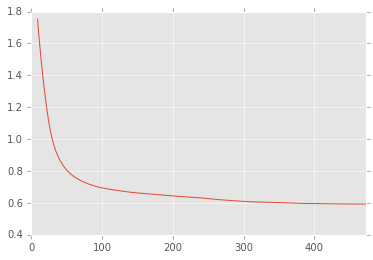

In [22]:
pd.Series(losses).rolling(10).mean().plot()

In [23]:
embeddings_df = pd.DataFrame(index=mnist_df_scaled.index, data=y_embeddings)

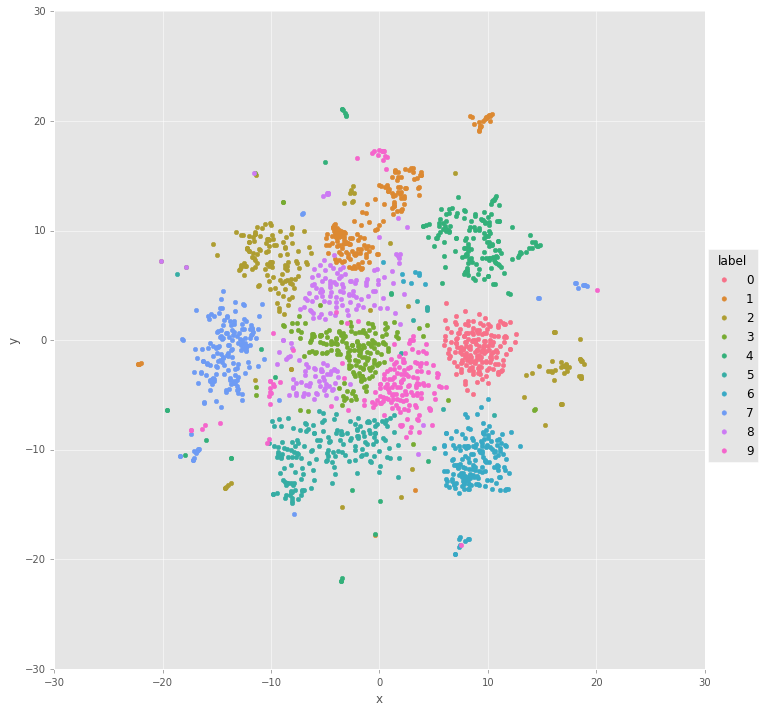

In [26]:
plot_source = embeddings_df.reset_index().rename(columns={
    'index': 'label', 0: 'x', 1:'y'})
fg = sns.FacetGrid(data=plot_source, hue='label', size=10)
fg.map(plt.scatter, 'x', 'y').add_legend()

Let's compare that against what the sklearn implementation gives us:

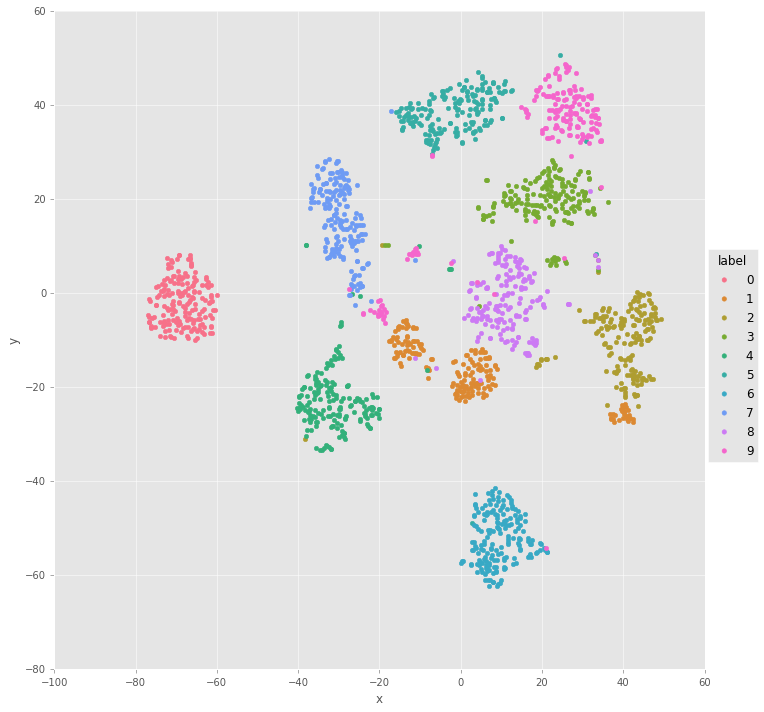

In [16]:
from sklearn.manifold import TSNE

# Extract the embeddings and convert into a DataFrame
sk_embedded = TSNE(n_components=2).fit_transform(mnist_df_scaled.values)
sk_embedded = pd.DataFrame(index=mnist_df_scaled.index, data=sk_embedded)

# Display
sk_embedded = sk_embedded.reset_index().rename(columns={'index': 'label', 0: 'x', 1:'y'})
fg = sns.FacetGrid(data=sk_embedded, hue='label', size=10)
fg.map(plt.scatter, 'x', 'y').add_legend()

# Appendix: Vectorized Calculation of $Q_{ij}$ in TensorFlow$ 

In [27]:
y = pd.DataFrame(index=range(3), columns=range(5), data=np.random.uniform(1, 5, size=[3, 5]))

In [28]:
y

,0,1,2,3,4
0,3.841796,2.343839,4.242634,4.119774,3.775773
1,2.196821,3.169581,3.726738,2.675542,4.937759
2,1.316947,4.095652,4.813276,2.686604,3.601084


First we calculate Q using the direct iterative algorithm which requires iterating over rows and columns of y this gives us a reference to test our vectorized implementation for correctness.

In [29]:
Q_simple = pd.DataFrame(index=y.index, columns=y.index, data=0.0)

for i in range(0, y.shape[0]):
    for j in range(0, i):
        assert i != j, (i, j)            
        md = y.loc[i, :].sub(y.loc[j, :])
        d = 1 + np.linalg.norm(md)**2
        Q_simple.loc[i, j] = 1 / d
        Q_simple.loc[j, i] = 1 / d        

Q_simple

,0,1,2
0,0.000000,0.123610,0.077798
1,0.123610,0.000000,0.178598
2,0.077798,0.178598,0.000000


To calculate Q in a vectorized way, we note that

$D[i, j] = (y[i] - y[j]) (y[i] - y[j])^T = norm(y[i])^2 + norm(y[j])^2 - 2 \times dot(a[i], a[j])$

For the entire 2D array y, we can generalize this to:

``D = np.atleast_2d(r) + np.atleast_2d(r).T - 2 * np.dot(y, y.T)``

where r is (vector) of norms of each vector in y.

In [30]:
norms = y.apply(np.linalg.norm, axis=1).values

r1 = np.atleast_2d(norms**2)
r2 = r1.T
d1 = r1 + r2

d2 = d1 - 2 * np.dot(y, y.T)
d2 += 1
d3 = 1 / d2

d3[np.diag_indices_from(d3)] = 0
Q_vectorized = pd.DataFrame(d3)

Q_vectorized

,0,1,2
0,0.000000,0.123610,0.077798
1,0.123610,0.000000,0.178598
2,0.077798,0.178598,0.000000


In [31]:
from pandas.util.testing import assert_frame_equal
assert_frame_equal(Q_simple, Q_vectorized, check_less_precise=True)

We can do the same in tensorflow by substituting the ``np.atleast_2d()`` function with ``tf.expand_dims()``, since tensorflow also supports broadcast.